# Health failure prediction using Machine Learning

## Setup

In [30]:
import os
import time
import pandas as pd
import numpy as np

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from scipy.stats import sem, t


In [31]:
# Dataset directory
data_root = "../../data/heart.csv"

# Models directory
models_dir = "../../models/"
os.makedirs(models_dir, exist_ok=True)

## Exploratory Data Analysis

### General observations

In [32]:
# Read the data
dataDF = pd.read_csv(data_root)
dataDF

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [33]:
# Count missing values
missing_values = dataDF.isnull().sum()
missing_values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Features analysis

#### Numeric features analysis

In [34]:
# Numeric features statistics
dataDF.drop(columns="HeartDisease").describe().T


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


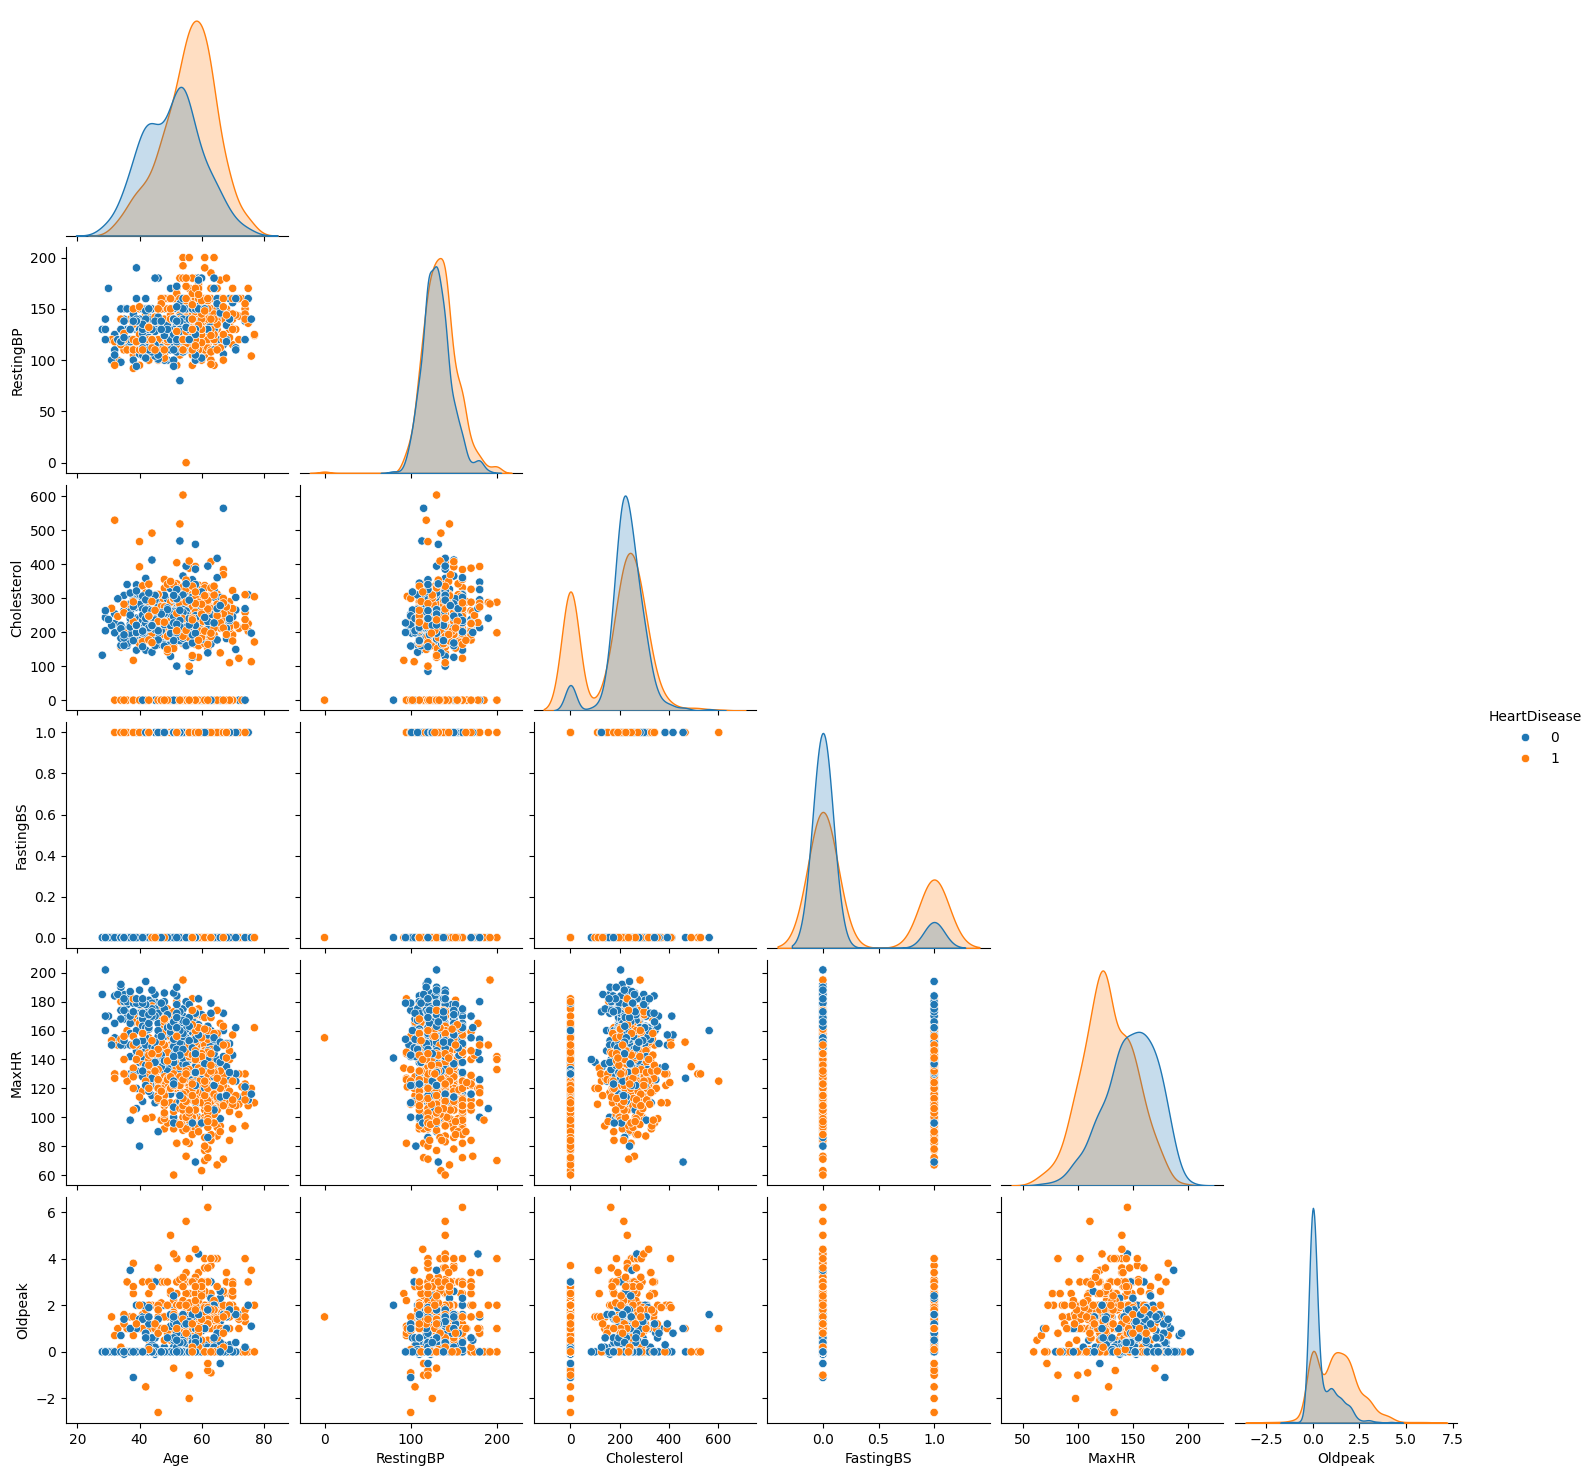

In [35]:
# Features distribution
sns.pairplot(dataDF, hue="HeartDisease", corner=True)
plt.show()

#### Categorical features analysis

In [36]:
# Catetorical features statistics
dataDF.select_dtypes(include=["object"]).describe().T


,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


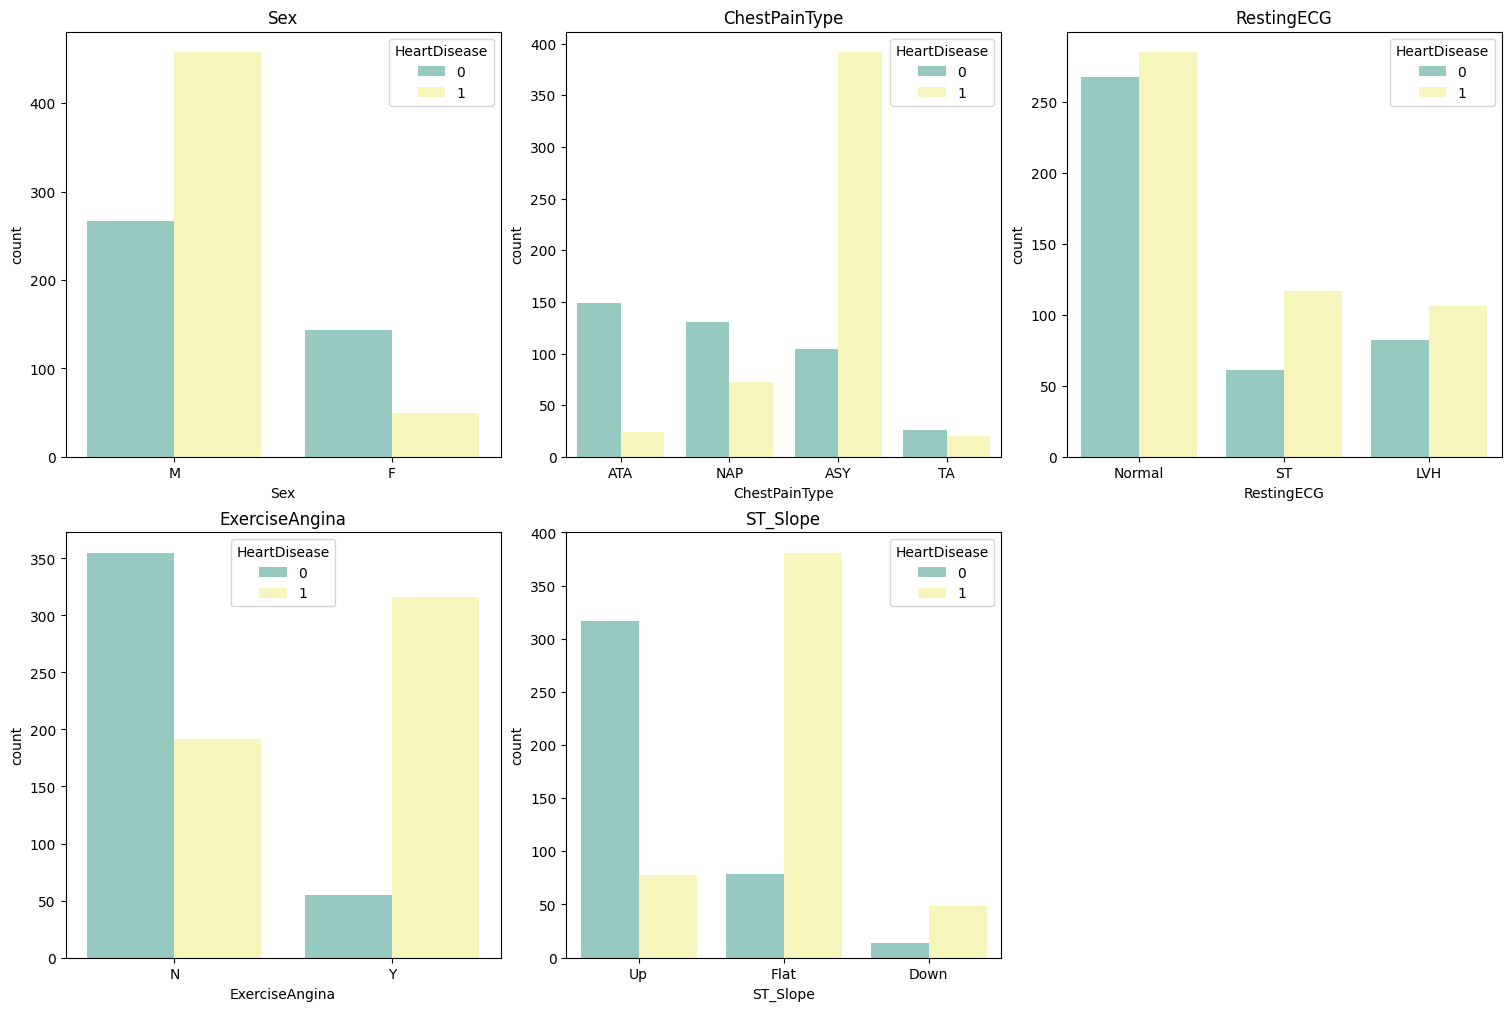

In [37]:
# Box plot for categorical features
cat_columns = dataDF.select_dtypes(include=["object"]).columns

num_cols = len(cat_columns)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5), constrained_layout=True)

axes = axes.flatten()

for i, col in enumerate(cat_columns):
    subplt = sns.countplot(x=col, data=dataDF, palette="Set3", hue="HeartDisease", ax=axes[i])
    subplt.set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

    

#### Class distribution

In [38]:
# Class distribution
dataDF["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

## Machine Learning framework

In [39]:
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
features = dataDF.drop('HeartDisease', axis=1)
target = dataDF['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target)

# Normalize numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), dataDF.columns[:-1].difference(categorical_features)),
        ('cat', OneHotEncoder(), categorical_features)
        ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
model_path = os.path.join(models_dir, "model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(clf, f)


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       103
           1       0.88      0.94      0.91       127

    accuracy                           0.90       230
   macro avg       0.90      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



In [40]:
fts = {'age': '4', 'sex': 'M', 'chestPainType': 'TA', 'restingBP': '51', 'cholesterol': '101', 'fastingBS': '1', 'restingECG': 'Normal', 'maxHR': '61', 'exerciseAngina': 'N', 'oldpeak': '0.2', 'stSlope': 'Flat'}

correct_col_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


# Create the new dataframe from the dictionary with correct column names
new_data = pd.DataFrame.from_dict(fts, orient='index').T
new_data.columns = correct_col_names
new_data

# Load the model
with open(model_path, "rb") as f:
    clf = pickle.load(f)

# Probability of each class
proba = clf.predict_proba(new_data)
print(proba)



[[0.24 0.76]]


### Model selection and hyperparameter tuning

In this section, a comprehensive machine learning pipeline was performed to predict heart disease using various classifiers and hyperparameter tuning. 

* Data preprocessing: A `ColumnTransformer` was employed to normalize numerical features using `StandardScaler` and one-hot encode the categorical features. 
* Three different models - RandomForest, SVM, and LogisticRegression - along with their respective hyperparameters to be tuned were defined. For each model, a pipeline was created that included the preprocessor and the classifier. `GridSearchCV` was used for hyperparameter tuning and cross-validation to find the best parameters for each model. The best estimator for each model was evaluated on the test set, and performance metrics such as F1 score and accuracy were computed.
* Cross-validation on the training set was conducted to calculate the mean, standard deviation, and 95% confidence intervals for both the F1 score and accuracy, providing a robust estimate of model selection.

In [41]:
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
features = dataDF.drop('HeartDisease', axis=1)
target = dataDF['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Normalize numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), dataDF.columns.difference(categorical_features + ['HeartDisease'])),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the models and their hyperparameters
models = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': [1, 0.1, 0.01],
            'classifier__kernel': ['linear','rbf']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1, 10]
        }
    }
}

results = {}

for model_name, config in models.items():
    # Create a pipeline for each model
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(clf, config['params'], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator and hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Measure inference time
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Evaluate on the test set
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Perform cross-validation to get confidence intervals
    cv_results = cross_val_score(clone(best_model), X_train, y_train, cv=5, scoring='f1')
    mean_f1 = np.mean(cv_results)
    std_f1 = np.std(cv_results)
    confidence_interval_f1 = t.interval(0.95, len(cv_results)-1, loc=mean_f1, scale=sem(cv_results))
    
    cv_results_acc = cross_val_score(clone(best_model), X_train, y_train, cv=5, scoring='accuracy')
    mean_acc = np.mean(cv_results_acc)
    std_acc = np.std(cv_results_acc)
    confidence_interval_acc = t.interval(0.95, len(cv_results_acc)-1, loc=mean_acc, scale=sem(cv_results_acc))
    
    results[model_name] = {
        'best_params': best_params,
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_accuracy': mean_acc,
        'std_accuracy': std_acc,
        'confidence_interval_f1': confidence_interval_f1,
        'confidence_interval_accuracy': confidence_interval_acc,
        'inference_time': inference_time
    }

# Print the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {result['best_params']}")
    print(f"Mean F1 Score: {result['mean_f1']}")
    print(f"Standard Deviation of F1 Score: {result['std_f1']}")
    print(f"Mean Accuracy: {result['mean_accuracy']}")
    print(f"Standard Deviation of Accuracy: {result['std_accuracy']}")
    print(f"95% Confidence Interval for F1 Score: {result['confidence_interval_f1']}")
    print(f"95% Confidence Interval for Accuracy: {result['confidence_interval_accuracy']}")
    print(f"Inference Time: {result['inference_time']} seconds")
    print("\n")

Model: RandomForest
Best Hyperparameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Mean F1 Score: 0.8751918423759555
Standard Deviation of F1 Score: 0.026463746594752785
Mean Accuracy: 0.8647942452131598
Standard Deviation of Accuracy: 0.025532019420128796
95% Confidence Interval for F1 Score: (0.8384542725268573, 0.9119294122250536)
95% Confidence Interval for Accuracy: (0.8293501200407439, 0.9002383703855757)
Inference Time: 0.008606910705566406 seconds


Model: SVM
Best Hyperparameters: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Mean F1 Score: 0.8890618892234377
Standard Deviation of F1 Score: 0.027706428991636094
Mean Accuracy: 0.874928594097112
Standard Deviation of Accuracy: 0.03222283531530905
95% Confidence Interval for F1 Score: (0.8505991996452684, 0.9275245788016069)
95% Confidence Interval for Accuracy: (0.8301961274037197, 0.9196610607905042)
Inference Time: 0.004416704177856445 seconds


Model: LogisticRegression
Be

### Final model training

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), dataDF.columns[:-1].difference(categorical_features)),
        ('cat', OneHotEncoder(), categorical_features)
        ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(C=1, gamma=0.1, kernel='rbf'))
])

clf.fit(X_train, y_train)

# Save the model
model_path = os.path.join(models_dir, "model.pkl")

### Test model - Final evaluation

Confusion Matrix:
[[ 96   2]
 [  3 129]]
Accuracy: 0.9782608695652174
F1 Score: 0.9809885931558935
Precision: 0.9847328244274809
Recall: 0.9772727272727273
ROC-AUC: 0.9884431045145331

Class-wise Metrics:

                 precision    recall  f1-score   support

No HeartDisease       0.97      0.98      0.97        98
   HeartDisease       0.98      0.98      0.98       132

       accuracy                           0.98       230
      macro avg       0.98      0.98      0.98       230
   weighted avg       0.98      0.98      0.98       230



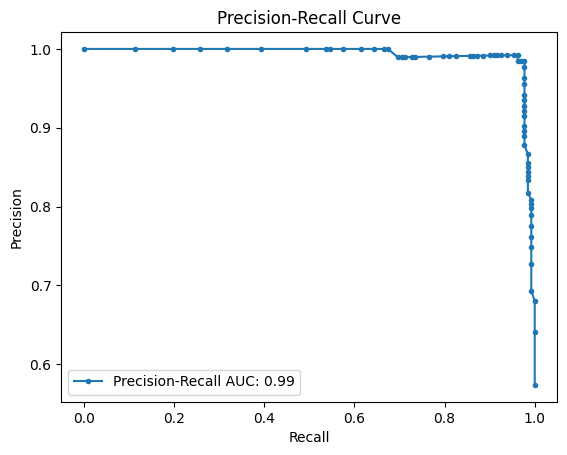

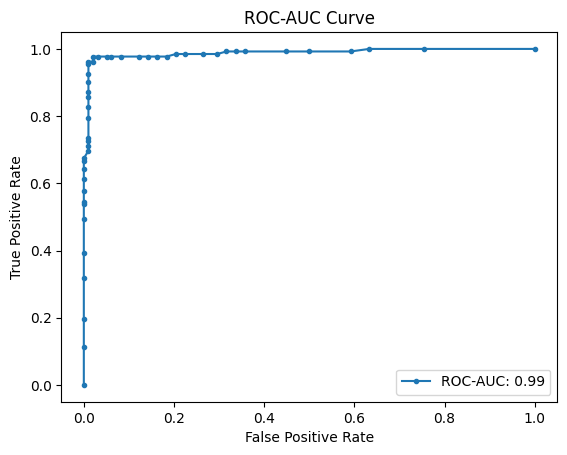

In [43]:
# Load the model
with open(model_path, "rb") as f:
    clf = pickle.load(f)

# Predict on the test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Generate class-wise metrics
class_report = classification_report(y_test, y_pred, target_names=['No HeartDisease', 'HeartDisease'])

# Print the metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")
print("\nClass-wise Metrics:\n")
print(class_report)

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.figure()
plt.plot(recall_vals, precision_vals, marker='.', label=f'Precision-Recall AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC: {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()